In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

In [39]:
df_new = pd.read_csv('Processed_Fatality_2022_2023_FE.csv')

In [143]:
# Prepare modeling data
df_model = df_new.dropna(subset=['delay_minutes'])

# Separate target and features
y = df_model['delay_minutes']
X = df_model.drop(['delay_hours', 'time_notified', 
                   'datetime_crash', 'datetime_not_crash', 
                   'date_crash','LATITUDE','LONGITUD',
                   'HOSP_HR','HOSP_MN',
                   'TWAY_ID2','OBJECTID',
                   'ST_CASE','FATALS','PEDS','PERSONS',
                   'PERNOTMVIT','PERMVIT','VE_TOTAL','VE_FORMS',
                   'PVH_INVL','x','y','HARM_EV',
                   "tm_crash","not_tm_crash",
                   "HOSP_HRNAME","HOSP_MNNAME",
                   "RAILNAME","SCH_BUSNAME",
                   "MAN_COLLNAME","HARM_EVNAME",'WRK_ZONENAME',
                   "MAN_COLL","LATITUDENAME","LONGITUDNAME",
                   "MINUTENAME","DAYNAME","YEAR","MINUTE","STATENAME","delay_minutes","delay_min_bin","delay_bin",
                   "delay_stat_bin","delay_adaptive_bin",
                   "delay_smart_bin","narrative_bin",
                   "delay_quantile_bin",
                   "survivor_category",
                   "people_not_dead","HOURNAME","HOUR",
                   "MILEPTNAME","MILEPT",
                   ], axis=1)


In [144]:
# Find columns that have both 'COLNAME' and 'COL' versions (where we want to keep 'COLNAME' and exclude 'COL')
cols_with_name_suffix = [col for col in X.columns if col.endswith('NAME')]
base_cols_to_exclude = []

for col_with_name in cols_with_name_suffix:
    # Remove 'NAME' suffix to get the base column name
    base_col = col_with_name[:-4]  # Remove last 4 characters ('NAME')
    
    # Check if the base column exists in the dataframe
    if base_col in X.columns:
        base_cols_to_exclude.append(base_col)
        print(f"Found pair: {base_col} and {col_with_name} - excluding {base_col}")

# Exclude columns that start with 'NOT' or 'ARR'
cols_to_exclude_start = [col for col in X.columns if col.startswith('NOT') or col.startswith('ARR')]

# Combine all columns to exclude
cols_to_exclude = list(set(cols_to_exclude_start + base_cols_to_exclude))

print(f"\nAll columns to exclude: {cols_to_exclude}")


Found pair: COUNTY and COUNTYNAME - excluding COUNTY
Found pair: CITY and CITYNAME - excluding CITY
Found pair: MONTH and MONTHNAME - excluding MONTH
Found pair: DAY_WEEK and DAY_WEEKNAME - excluding DAY_WEEK
Found pair: ROUTE and ROUTENAME - excluding ROUTE
Found pair: RUR_URB and RUR_URBNAME - excluding RUR_URB
Found pair: FUNC_SYS and FUNC_SYSNAME - excluding FUNC_SYS
Found pair: RD_OWNER and RD_OWNERNAME - excluding RD_OWNER
Found pair: NHS and NHSNAME - excluding NHS
Found pair: SP_JUR and SP_JURNAME - excluding SP_JUR
Found pair: RELJCT1 and RELJCT1NAME - excluding RELJCT1
Found pair: RELJCT2 and RELJCT2NAME - excluding RELJCT2
Found pair: TYP_INT and TYP_INTNAME - excluding TYP_INT
Found pair: REL_ROAD and REL_ROADNAME - excluding REL_ROAD
Found pair: LGT_COND and LGT_CONDNAME - excluding LGT_COND
Found pair: WEATHER and WEATHERNAME - excluding WEATHER
Found pair: NOT_HOUR and NOT_HOURNAME - excluding NOT_HOUR
Found pair: NOT_MIN and NOT_MINNAME - excluding NOT_MIN
Found pair: A

In [145]:
# Drop the excluded columns that exist in the DataFrame
X = X.drop(columns=[col for col in cols_to_exclude if col in X.columns])

In [146]:
X.shape

(29875, 23)

In [147]:
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols

Index(['COUNTYNAME', 'CITYNAME', 'MONTHNAME', 'DAY_WEEKNAME', 'TWAY_ID',
       'ROUTENAME', 'RUR_URBNAME', 'FUNC_SYSNAME', 'RD_OWNERNAME', 'NHSNAME',
       'SP_JURNAME', 'RELJCT1NAME', 'RELJCT2NAME', 'TYP_INTNAME',
       'REL_ROADNAME', 'LGT_CONDNAME', 'WEATHERNAME', 'RAIL', 'time_period'],
      dtype='object')

In [148]:
encoder = ce.TargetEncoder(cols=categorical_cols)
X = encoder.fit_transform(X, y)
X.shape

(29875, 23)

In [149]:
# Keep only numeric features
# X = X.select_dtypes(include=[np.number])

# Handle infinite values and missing data
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

print(f"Dataset shape: {X.shape}")
print(f"Target variable range: {y.min():.2f} to {y.max():.2f} hours")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dataset shape: (29875, 23)
Target variable range: 0.00 to 1438.00 hours


In [150]:
#############################################
# Linear Regression Model
#############################################
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Metrics for Linear Regression
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print("\n=== Linear Regression Results ===")
print(f"RMSE: {rmse_linear:.4f}")
print(f"R²: {r2_linear:.4f}")
print(f"MAE: {mae_linear:.4f}")

#############################################
# Random Forest Regression Model
#############################################
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Metrics for Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\n=== Random Forest Results ===")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")

#############################################
# XGBoost Regression Model
#############################################
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Metrics for XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("\n=== XGBoost Results ===")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")

#############################################
# Feature Importance Analysis
#############################################
# Get feature importance from Random Forest
rf_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Get feature importance from XGBoost
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Combine top features from both models
top_rf_features = rf_importance.sort_values(ascending=False).head(10)
top_xgb_features = xgb_importance.sort_values(ascending=False).head(10)

print("\n=== Top 10 Features from Random Forest ===")
for feature, importance in top_rf_features.items():
    print(f"{feature}: {importance:.4f}")

print("\n=== Top 10 Features from XGBoost ===")
for feature, importance in top_xgb_features.items():
    print(f"{feature}: {importance:.4f}")


=== Linear Regression Results ===
RMSE: 32.1423
R²: 0.4970
MAE: 12.6510

=== Random Forest Results ===
RMSE: 27.8714
R²: 0.6218
MAE: 5.8980

=== XGBoost Results ===
RMSE: 28.9853
R²: 0.5909
MAE: 6.6937

=== Top 10 Features from Random Forest ===
TWAY_ID: 0.4929
COUNTYNAME: 0.1725
CITYNAME: 0.0527
MONTHNAME: 0.0372
DAY: 0.0306
STATE: 0.0305
ROUTENAME: 0.0295
LGT_CONDNAME: 0.0251
REL_ROADNAME: 0.0228
DAY_WEEKNAME: 0.0212

=== Top 10 Features from XGBoost ===
TWAY_ID: 0.1354
LGT_CONDNAME: 0.0992
NHSNAME: 0.0991
RELJCT2NAME: 0.0920
COUNTYNAME: 0.0803
RUR_URBNAME: 0.0698
time_period: 0.0647
MONTHNAME: 0.0498
REL_ROADNAME: 0.0417
ROUTENAME: 0.0417


In [151]:
import joblib
import pickle

# Save all three models
print("Saving trained models...")

# Method 1: Using joblib (recommended for scikit-learn models)
joblib.dump(linear_model, 'linear_regression_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')

# Save the target encoder as well (important for predictions!)
joblib.dump(encoder, 'target_encoder.pkl')

# Save feature names and model metadata
model_metadata = {
    'feature_names': X_train.columns.tolist(),
    'target_variable': 'delay_hours',
    'categorical_features': list(categorical_cols),
    'numerical_features': [col for col in X_train.columns if col not in categorical_cols],
    'model_performance': {
        'linear_regression': {'RMSE': rmse_linear, 'R2': r2_linear, 'MAE': mae_linear},
        'random_forest': {'RMSE': rmse_rf, 'R2': r2_rf, 'MAE': mae_rf},
        'xgboost': {'RMSE': rmse_xgb, 'R2': r2_xgb, 'MAE': mae_xgb}
    }
}

# Save metadata
with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)

print("✅ Models saved successfully!")
print("Files created:")
print("- linear_regression_model.pkl")
print("- random_forest_model.pkl") 
print("- xgboost_model.pkl")
print("- target_encoder.pkl")
print("- model_metadata.pkl")

Saving trained models...
✅ Models saved successfully!
Files created:
- linear_regression_model.pkl
- random_forest_model.pkl
- xgboost_model.pkl
- target_encoder.pkl
- model_metadata.pkl


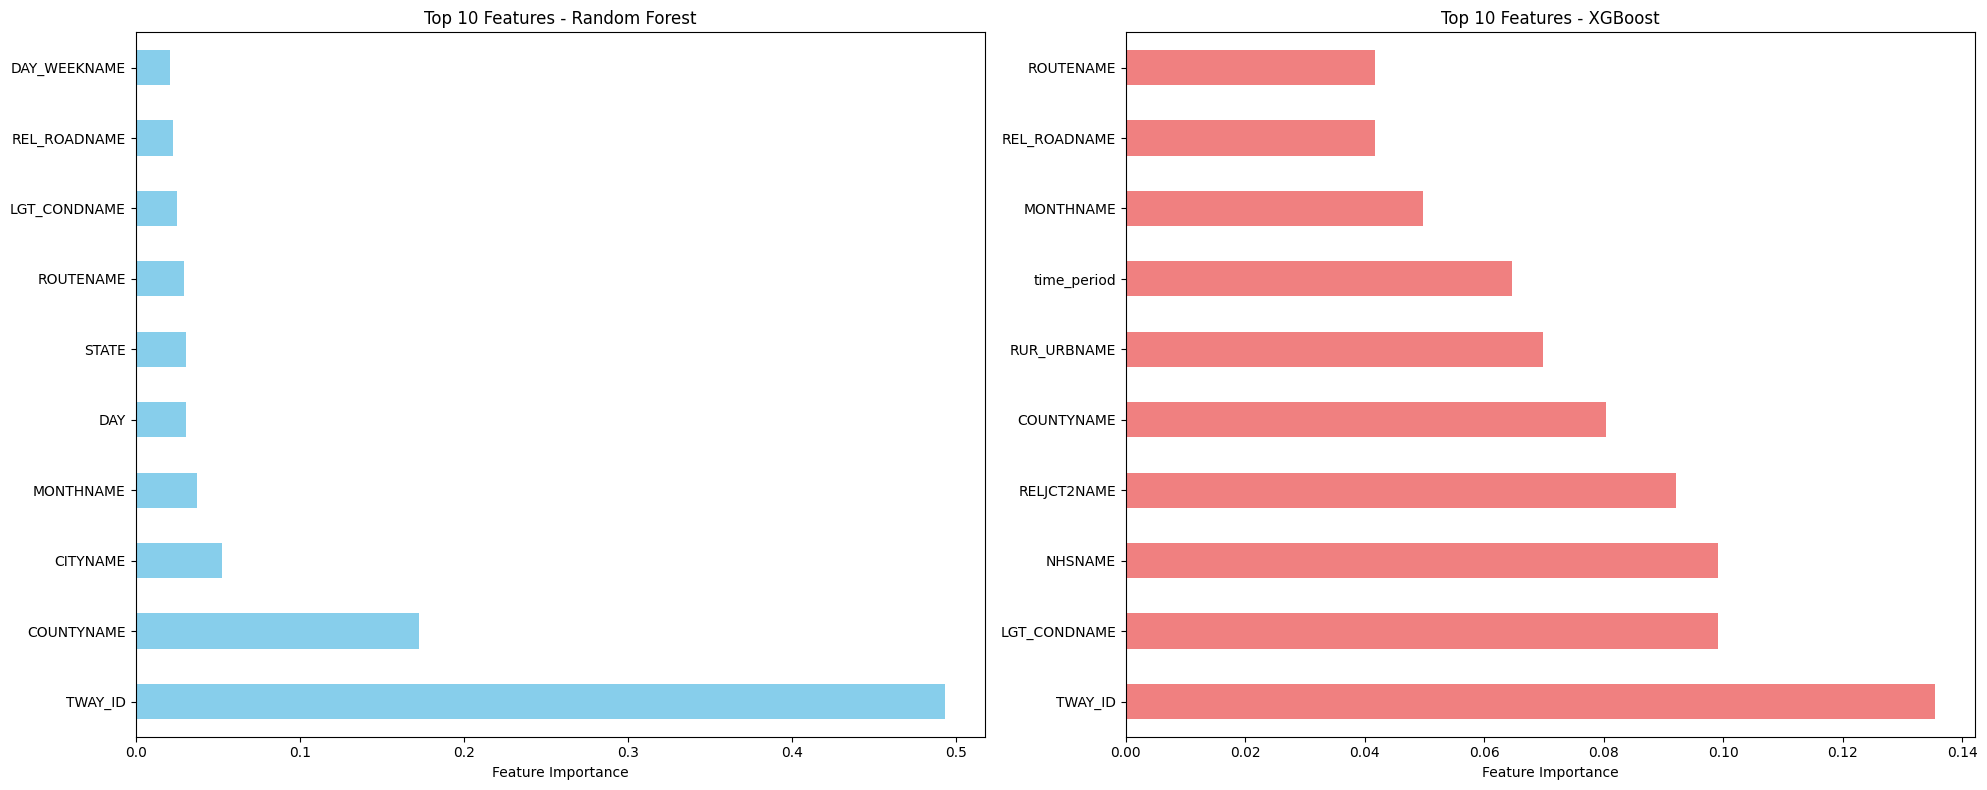

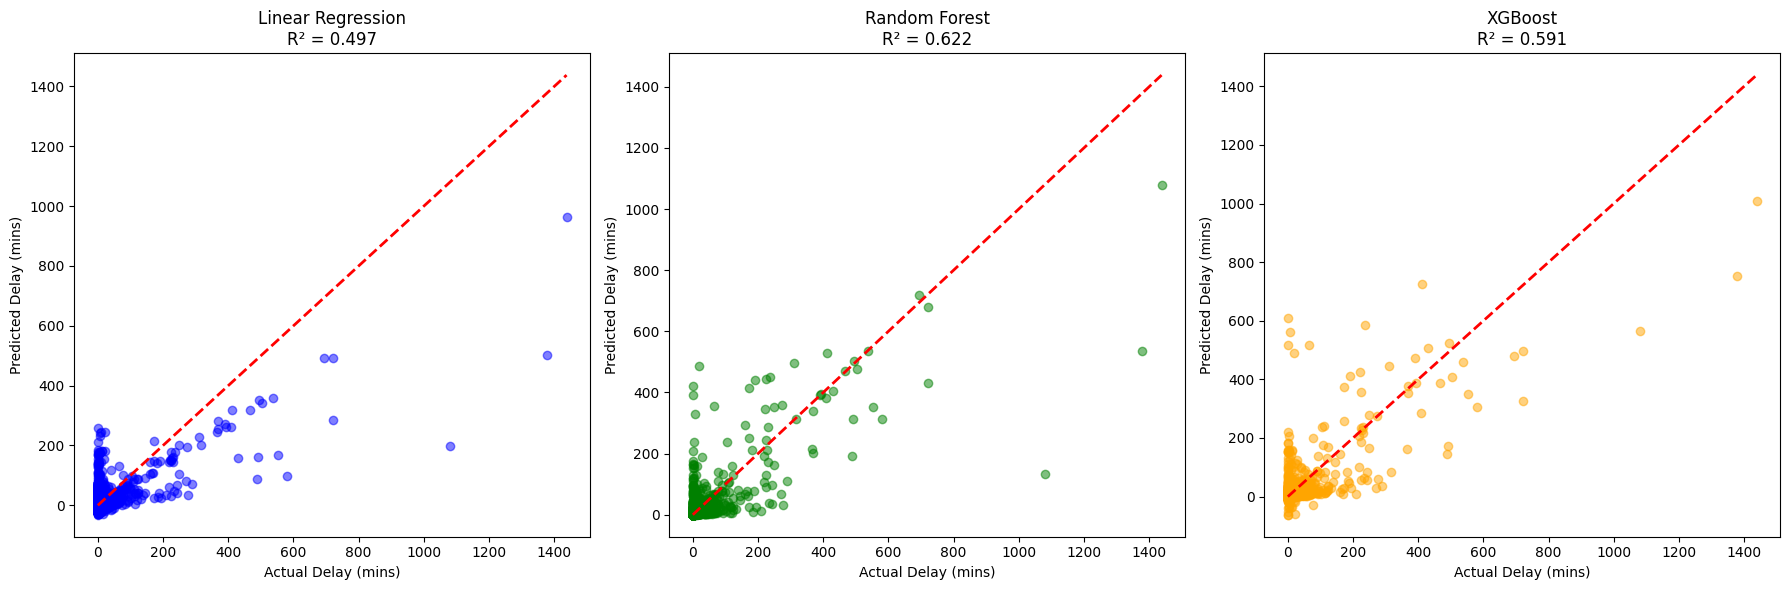

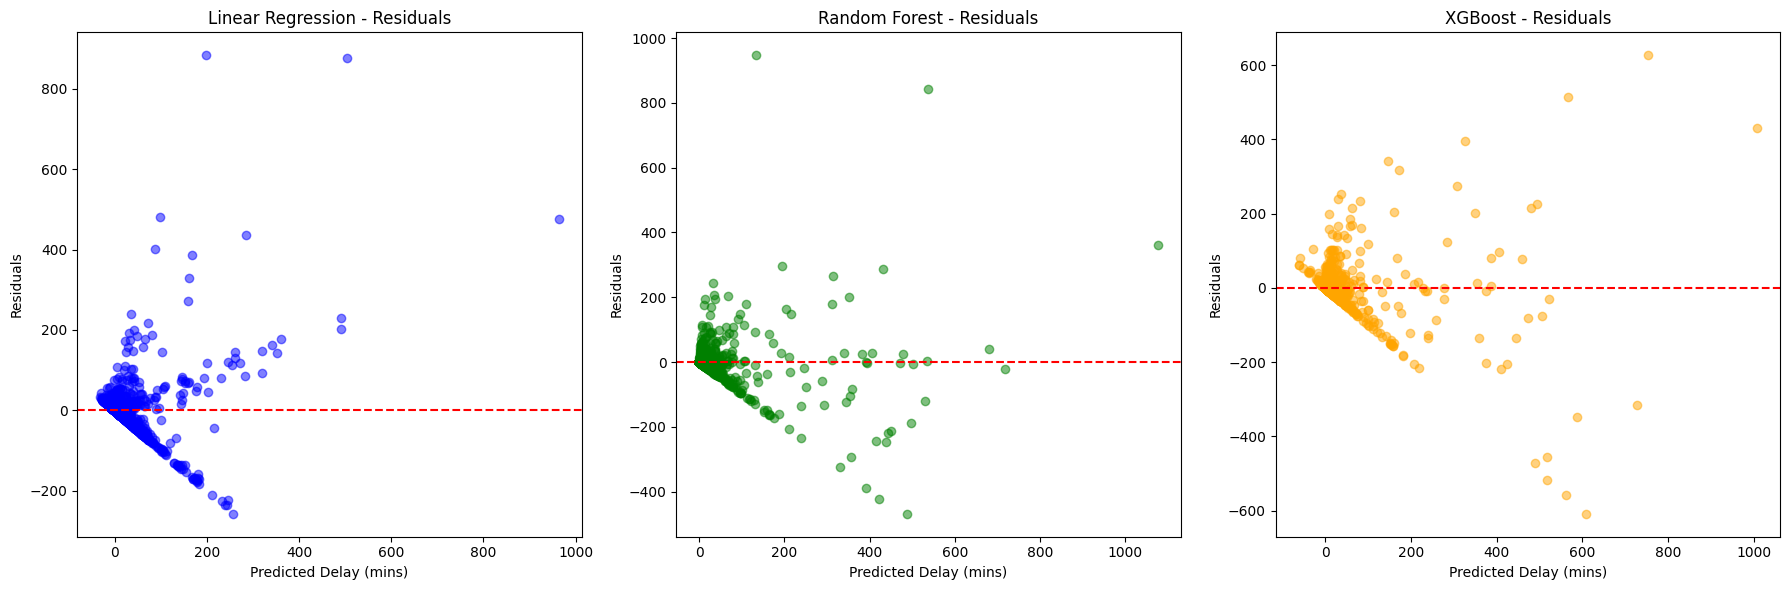

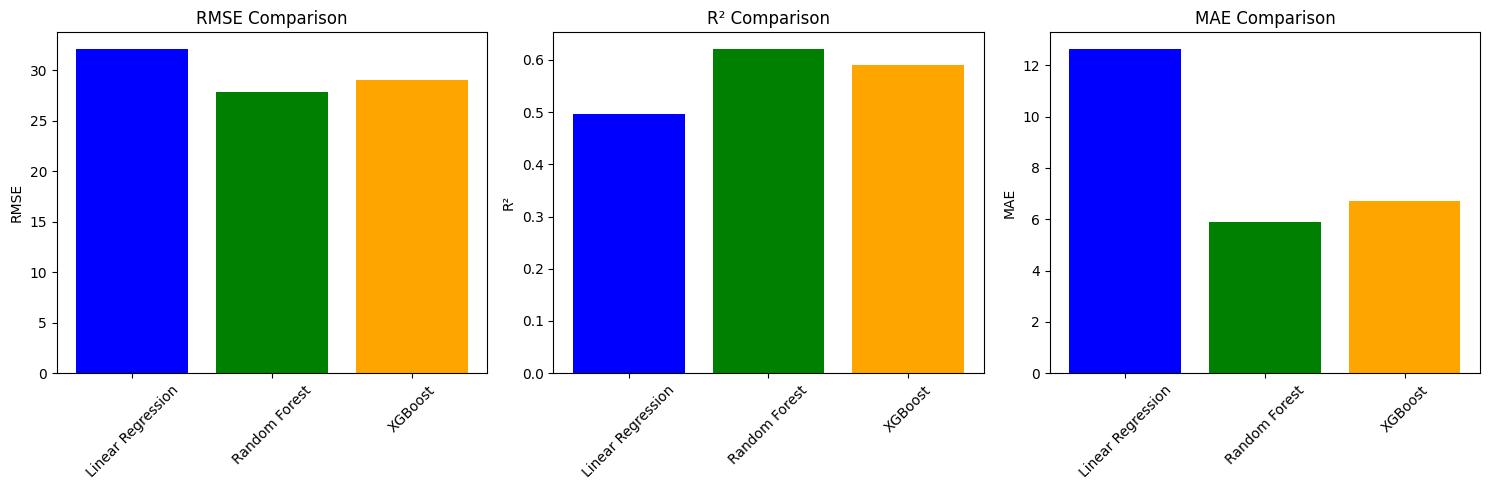


=== Model Comparison ===
               Model       RMSE        R²        MAE
0  Linear Regression  32.142292  0.496958  12.650978
1      Random Forest  27.871369  0.621760   5.897991
2            XGBoost  28.985292  0.590922   6.693651

=== Best Models ===
Best RMSE (lowest): Random Forest
Best R² (highest): Random Forest
Best MAE (lowest): Random Forest


In [152]:
# 1. Feature Importance Plot - Side by side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest Feature Importance
top_rf_features.plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Top 10 Features - Random Forest')
axes[0].set_xlabel('Feature Importance')

# XGBoost Feature Importance
top_xgb_features.plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title('Top 10 Features - XGBoost')
axes[1].set_xlabel('Feature Importance')

plt.tight_layout()
plt.show()

# 2. Predicted vs Actual for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Linear Regression
axes[0].scatter(y_test, y_pred_linear, alpha=0.5, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Delay (mins)')
axes[0].set_ylabel('Predicted Delay (mins)')
axes[0].set_title(f'Linear Regression\nR² = {r2_linear:.3f}')

# Random Forest
axes[1].scatter(y_test, y_pred_rf, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Delay (mins)')
axes[1].set_ylabel('Predicted Delay (mins)')
axes[1].set_title(f'Random Forest\nR² = {r2_rf:.3f}')

# XGBoost
axes[2].scatter(y_test, y_pred_xgb, alpha=0.5, color='orange')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Delay (mins)')
axes[2].set_ylabel('Predicted Delay (mins)')
axes[2].set_title(f'XGBoost\nR² = {r2_xgb:.3f}')

plt.tight_layout()
plt.show()

# 3. Residuals plot for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Linear regression residuals
residuals_linear = y_test - y_pred_linear
axes[0].scatter(y_pred_linear, residuals_linear, alpha=0.5, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Delay (mins)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Linear Regression - Residuals')

# Random forest residuals
residuals_rf = y_test - y_pred_rf
axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Delay (mins)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Random Forest - Residuals')

# XGBoost residuals
residuals_xgb = y_test - y_pred_xgb
axes[2].scatter(y_pred_xgb, residuals_xgb, alpha=0.5, color='orange')
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Predicted Delay (mins)')
axes[2].set_ylabel('Residuals')
axes[2].set_title('XGBoost - Residuals')

plt.tight_layout()
plt.show()

# 4. Model Performance Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = ['Linear Regression', 'Random Forest', 'XGBoost']
rmse_values = [rmse_linear, rmse_rf, rmse_xgb]
r2_values = [r2_linear, r2_rf, r2_xgb]
mae_values = [mae_linear, mae_rf, mae_xgb]

# RMSE Comparison
axes[0].bar(models, rmse_values, color=['blue', 'green', 'orange'])
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE Comparison')
axes[0].tick_params(axis='x', rotation=45)

# R² Comparison
axes[1].bar(models, r2_values, color=['blue', 'green', 'orange'])
axes[1].set_ylabel('R²')
axes[1].set_title('R² Comparison')
axes[1].tick_params(axis='x', rotation=45)

# MAE Comparison
axes[2].bar(models, mae_values, color=['blue', 'green', 'orange'])
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE Comparison')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#############################################
# Model Comparison Summary (Updated)
#############################################
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [rmse_linear, rmse_rf, rmse_xgb],
    'R²': [r2_linear, r2_rf, r2_xgb],
    'MAE': [mae_linear, mae_rf, mae_xgb]
})

print("\n=== Model Comparison ===")
print(comparison_df)

# Find best model for each metric
best_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
best_r2 = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
best_mae = comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']

print(f"\n=== Best Models ===")
print(f"Best RMSE (lowest): {best_rmse}")
print(f"Best R² (highest): {best_r2}")
print(f"Best MAE (lowest): {best_mae}")